In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import os
import cv2
#import skimage.io as io
#import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
# Input data files are available in the read-only "../input/" directory
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 56.0 MB/s eta 0:00:00


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow_io as tfio
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
import os
import numpy as np
import cv2
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# define image and mask directories



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ipythonx/retinal-vessel-segmentation

 98% 439M/448M [00:04<00:00, 147MB/s]
100% 448M/448M [00:04<00:00, 102MB/s]


In [ ]:
! unzip retinal-vessel-segmentation.zip

In [ ]:
# import os
# import shutil

# # Path to the train and test directories
# train_dir = '/content/DRIVE/training'
# test_dir = '/content/DRIVE/test'

# # Create a new directory to merge the data into
# merged_dir = '/content/DRIVE/data'
# os.makedirs(merged_dir)

# # Merge the images and masks folders within the train directory
# for folder in ['images', '1st_manual']:
#     src = os.path.join(train_dir, folder)
#     dst = os.path.join(merged_dir, folder)
#     shutil.copytree(src, dst)

# # Merge the images and masks folders within the test directory
# for folder in ['images', 'masks']:
#     src = os.path.join(test_dir, folder)
#     dst = os.path.join(merged_dir, folder)
#     shutil.copytree(src, dst)


In [ ]:
import os
from sklearn.model_selection import train_test_split
import shutil

# Define the path to your image and mask folders
image_folder_path = '/content/HRF/images'
mask_folder_path = '/content/HRF/manual1'

# Define the path to the directory where you want to save the splits
base_dir = '/content/HRF'

# Create the directory structure
os.makedirs(os.path.join(base_dir, 'train', 'image'))
os.makedirs(os.path.join(base_dir, 'train', 'mask'))
os.makedirs(os.path.join(base_dir, 'val', 'image'))
os.makedirs(os.path.join(base_dir, 'val', 'mask'))
os.makedirs(os.path.join(base_dir, 'test', 'image'))
os.makedirs(os.path.join(base_dir, 'test', 'mask'))

# Get the list of image and mask filenames
image_filenames = os.listdir(image_folder_path)
mask_filenames = os.listdir(mask_folder_path)

# Split the data into training, validation, and test sets
train_image_filenames, test_image_filenames, train_mask_filenames, test_mask_filenames = train_test_split(
    image_filenames, mask_filenames, test_size=0.2, random_state=42)

val_image_filenames, test_image_filenames, val_mask_filenames, test_mask_filenames = train_test_split(
    test_image_filenames, test_mask_filenames, test_size=0.3, random_state=42)

# Copy the training images and masks to the train directory
for filename in train_image_filenames:
    src_image = os.path.join(image_folder_path, filename)
    dst_image = os.path.join(base_dir, 'train', 'image', filename)
    shutil.copy(src_image, dst_image)

for filename in train_mask_filenames:
    src_mask = os.path.join(mask_folder_path, filename)
    dst_mask = os.path.join(base_dir, 'train', 'mask', filename)
    shutil.copy(src_mask, dst_mask)

# Copy the validation images and masks to the val directory
for filename in val_image_filenames:
    src_image = os.path.join(image_folder_path, filename)
    dst_image = os.path.join(base_dir, 'val', 'image', filename)
    shutil.copy(src_image, dst_image)

for filename in val_mask_filenames:
    src_mask = os.path.join(mask_folder_path, filename)
    dst_mask = os.path.join(base_dir, 'val', 'mask', filename)
    shutil.copy(src_mask, dst_mask)

# Copy the test images and masks to the test directory
for filename in test_image_filenames:
    src_image = os.path.join(image_folder_path, filename)
    dst_image = os.path.join(base_dir, 'test', 'image', filename)
    shutil.copy(src_image, dst_image)

for filename in test_mask_filenames:
    src_mask = os.path.join(mask_folder_path, filename)
    dst_mask = os.path.join(base_dir, 'test', 'mask', filename)
    shutil.copy(src_mask, dst_mask)


In [ ]:
shutil.rmtree(image_folder_path)
shutil.rmtree(mask_folder_path)

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, images_dir, masks_dir, batch_size, seed=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.batch_size = batch_size
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))
        self.seed = seed
        np.random.seed(self.seed)

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_image_filenames = self.image_filenames[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_mask_filenames = self.mask_filenames[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_images = []
        batch_masks = []
        for image_filename, mask_filename in zip(batch_image_filenames, batch_mask_filenames):
            image_path = os.path.join(self.images_dir, image_filename)
            mask_path = os.path.join(self.masks_dir, mask_filename)
            image = load_images(image_path) # replace with your image loading function
            mask_32_channels = load_masks(mask_path) # apply your function
            batch_images.append(image)
            batch_masks.append(mask_32_channels)
        return np.array(batch_images), np.array(batch_masks)


In [ ]:
IMAGE_SIZE = 1440
BATCH_SIZE = 3

In [ ]:
def load_masks(image_path):
    image = tf.io.read_file(image_path)
    image = tfio.experimental.image.decode_tiff(image) # out: (h, w, 4)
    image = image[:,:,:3] # out: (h, w, 3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.image.rgb_to_grayscale(image) # out: (h, w, 1)
    image = image / 255.
    return image

In [ ]:
def load_images(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image) # out: (1, h, w, 3)
    image = tf.divide(image, 255)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image, tf.int32)
    return image

In [ ]:
seed = 24
generator = CustomDataGenerator(images_dir='/content/HRF/train/image', masks_dir='/content/HRF/train/mask', batch_size=BATCH_SIZE ,seed = seed)
val_generator = CustomDataGenerator(images_dir='/content/HRF/val/image', masks_dir='/content/HRF/val/mask', batch_size=BATCH_SIZE , seed = seed)

In [ ]:
x,y = val_generator.__getitem__(1)
print(x.shape, y.shape)

(3, 1440, 1440, 3) (3, 1440, 1440, 1)


Images


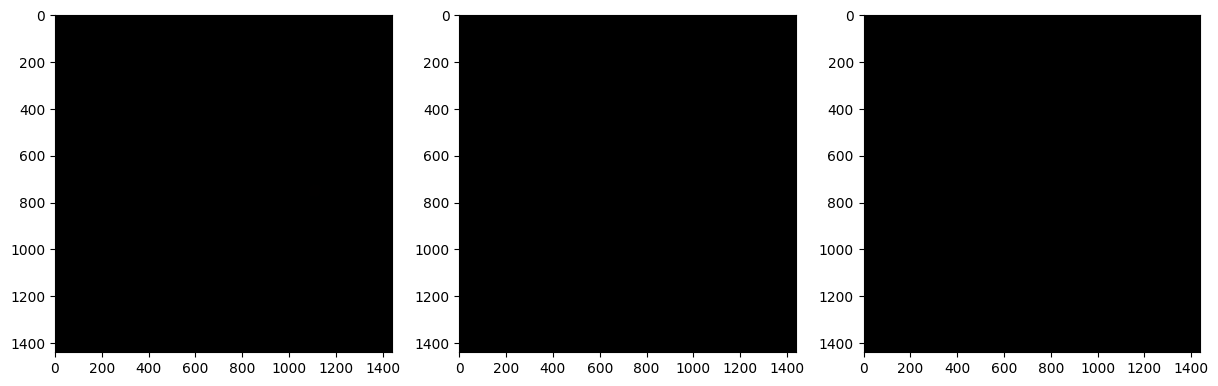

Masks


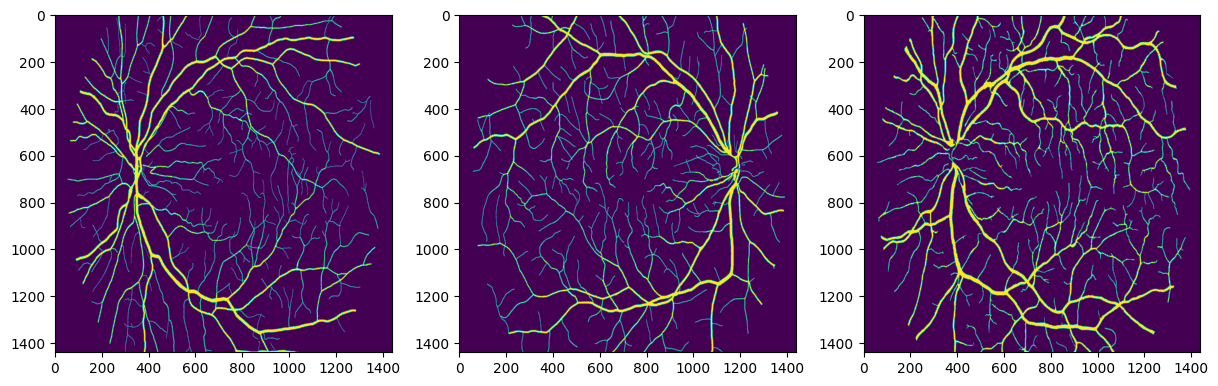

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
print("Images")
for i in range(3):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i])
plt.show()
print("Masks")
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(2, 4, i+1)
    plt.imshow(y[i])
plt.show()